In [1]:
import pandas as pd # DataFrame library
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
chess_games_2023 = pd.read_csv("./data/chess_games_2023.csv") # loads the 2023 data
chess_games_2024 = pd.read_csv("./data/chess_games_2024.csv") # loads the 2024 data
chess_games = pd.concat([chess_games_2023, chess_games_2024], ignore_index = True) # combines both years of data

In [3]:
chess_games.info() # Gives us an overview of the combined dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        671 non-null    int64  
 1   url               671 non-null    object 
 2   pgn               671 non-null    object 
 3   time_control      671 non-null    object 
 4   end_time          671 non-null    int64  
 5   rated             671 non-null    bool   
 6   tcn               671 non-null    object 
 7   uuid              671 non-null    object 
 8   initial_setup     671 non-null    object 
 9   fen               671 non-null    object 
 10  time_class        671 non-null    object 
 11  rules             671 non-null    object 
 12  white.rating      671 non-null    int64  
 13  white.result      671 non-null    object 
 14  white.@id         671 non-null    object 
 15  white.username    671 non-null    object 
 16  white.uuid        671 non-null    object 
 1

In [4]:
chess_games_2023.shape # the number of rows and columns for the 2023 games

(495, 25)

In [5]:
chess_games_2024.shape # the number of rows and columns for the 2024 games

(176, 25)

In [6]:
assert chess_games_2023.shape[0] + chess_games_2024.shape[0] == chess_games.shape[0] # Tests to make sure that the 2023 and 2024 dataframes add up (if successful there shouldn't be an output)

In [7]:
chess_games.columns # the columns currently in the dataframe

Index(['Unnamed: 0', 'url', 'pgn', 'time_control', 'end_time', 'rated', 'tcn',
       'uuid', 'initial_setup', 'fen', 'time_class', 'rules', 'white.rating',
       'white.result', 'white.@id', 'white.username', 'white.uuid',
       'black.rating', 'black.result', 'black.@id', 'black.username',
       'black.uuid', 'start_time', 'accuracies.white', 'accuracies.black'],
      dtype='object')

In [8]:
columns_to_drop = ["Unnamed: 0", "url", "rated", "tcn", "uuid", "initial_setup", "accuracies.white", "accuracies.black", 
                   "fen", "rules", "white.@id", "white.uuid", "black.@id", "black.uuid"]
chess_games.drop(columns = columns_to_drop, inplace = True)

In [9]:
chess_games["time_class"].unique() # types of games that were played

array(['blitz', 'bullet', 'daily', 'rapid'], dtype=object)

In [10]:
print(np.sort(chess_games["white.result"].unique())) # unique results for white and black (it will be the same results regardless of what column gets picked)

['abandoned' 'checkmated' 'insufficient' 'repetition' 'resigned'
 'stalemate' 'timeout' 'timevsinsufficient' 'win']


In [11]:
def game_results(df):
    """Determines if I won a game, drew it, or lost it.

    Args:
        df (pandas.DataFrame): the data that contains all the chess games

    Returns:
        str : Returns one of three outcomes (Won, Lost, or Draw)
    """
    results = []
    for white_result, white_username, black_result, black_username in zip(df["white.result"], df["white.username"], df["black.result"], df["black.username"]):
        if (white_result == "win" and white_username == "hfactor13") or (black_result == "win" and black_username == "hfactor13"):
            results.append("Won")
        elif white_result == black_result:
            results.append("Draw")
        else:
            results.append("Lost")
    return results

In [12]:
chess_games["game_result"] = game_results(chess_games) # put the results into a column for future aggregation and transformation operations

In [13]:
# Writing out PGN data to a file (this will be helpful to extract missing information that wasn't already available in the API)
pgn_data = chess_games["pgn"]
with open("./data/pgn_data.pgn", "w") as p:
    p.writelines(pgn_data + "\n")

In [14]:
# Reading in the data from the newly created PGN file to extract information (i.e. the start and end times and the dates)
with open("./data/pgn_data.pgn", "r") as p:
    pgn_text = p.readlines()
pgn_text[:24]

['[Event "Live Chess"]\n',
 '[Site "Chess.com"]\n',
 '[Date "2023.01.18"]\n',
 '[Round "-"]\n',
 '[White "hfactor13"]\n',
 '[Black "MrEvi10verlord"]\n',
 '[Result "0-1"]\n',
 '[CurrentPosition "r6k/ppp4p/2n1r3/8/1nPp4/1P3p2/P1q5/RK4R1 w - -"]\n',
 '[Timezone "UTC"]\n',
 '[ECO "A01"]\n',
 '[ECOUrl "https://www.chess.com/openings/Nimzowitsch-Larsen-Attack-Modern-Variation"]\n',
 '[UTCDate "2023.01.18"]\n',
 '[UTCTime "02:03:52"]\n',
 '[WhiteElo "660"]\n',
 '[BlackElo "795"]\n',
 '[TimeControl "180"]\n',
 '[Termination "MrEvi10verlord won by checkmate"]\n',
 '[StartTime "02:03:52"]\n',
 '[EndDate "2023.01.18"]\n',
 '[EndTime "02:08:39"]\n',
 '[Link "https://www.chess.com/game/live/67746611751"]\n',
 '\n',
 '1. b3 {[%clk 0:02:55.3]} 1... e5 {[%clk 0:02:59.8]} 2. Nf3 {[%clk 0:02:50.5]} 2... Nc6 {[%clk 0:02:58]} 3. g3 {[%clk 0:02:48.6]} 3... d5 {[%clk 0:02:57.8]} 4. c4 {[%clk 0:02:42.1]} 4... Bc5 {[%clk 0:02:54.4]} 5. Bb2 {[%clk 0:02:35.1]} 5... f6 {[%clk 0:02:46.2]} 6. h4 {[%clk 0:02:27.3]}

In [15]:
# Parsing text for dates, times, openings, moves, and link to the game
start_times_info = []
end_times_info = []
start_dates_info = []
end_dates_info = []
openings = []
moves = []
url_link = []

for text in pgn_text:
    if re.match("\[StartTime", text):
        start_times_info.append(text)
    elif re.match("\[EndTime", text):
        end_times_info.append(text)
    elif re.match("\[Date", text):
        start_dates_info.append(text)
    elif re.match("\[EndDate", text):
        end_dates_info.append(text)
    elif re.match("\[ECOUrl", text):
        openings.append(text)
    elif re.match("1\.", text):
        moves.append(text)
    elif re.match("\[Link", text):
        url_link.append(text)

In [16]:
openings = [o[40:].strip().strip("]").strip("\"") for o in openings] # strips out the unneccessary characters at the end (", ], \n)
openings

['Nimzowitsch-Larsen-Attack-Modern-Variation',
 'Modern-Defense-with-1-e4-2.d4-Bg7-3.Be3',
 'Nimzowitsch-Larsen-Attack-Dutch-Variation',
 'Reti-Opening-Kingside-Fianchetto-Variation',
 'Nimzowitsch-Larsen-Attack-Classical-Variation-2.Bb2',
 'English-Opening-Kings-English-Variation-2.b3-Nc6-3.Bb2',
 'Petrovs-Defense-3.d3-Nc6-4.Be2',
 'Queens-Gambit',
 'Indian-Game-2.e3',
 'Caro-Kann-Defense-Two-Knights-Attack',
 'Scotch-Game-3...exd4-4.Nxd4-Nxd4-5.Qxd4',
 'Scandinavian-Defense',
 'Vienna-Game-Falkbeer-Stanley-Variation',
 'Center-Game-Accepted-3.Qxd4',
 'Three-Knights-Opening-3...Bb4',
 'Queens-Pawn-Opening-Accelerated-London-System-2...Bf5-3.e3',
 'Petrovs-Defense-Three-Knights-Game',
 'Owens-Defense-2.d4-Bb7-3.f3',
 'Kings-Pawn-Opening-Leonardis-Variation',
 'Petrovs-Defense-Urusov-Gambit',
 'Vienna-Game-Max-Lange-Defense-3.Bc4',
 'Kings-Pawn-Opening-The-Whale-Variation',
 'Indian-Game-Omega-Gambit',
 'Three-Knights-Opening',
 'Kings-Fianchetto-Opening-1...e5-2.Bg2-d5',
 'Scotch-Game-

In [17]:
last_moves = [m[-50:] for m in moves] # looking at the last 50 characters to determine the total number of moves in the game
last_moves

['clk 0:00:07.4]} 29... Qc2# {[%clk 0:01:20.2]} 0-1\n',
 ' {[%clk 0:00:21.2]} 21. g3 {[%clk 0:00:45.3]} 1-0\n',
 '[%clk 0:00:01.1]} 25... h6 {[%clk 0:00:09.9]} 0-1\n',
 '[%clk 0:00:55.3]} 32. Rxh4 {[%clk 0:02:39.7]} 1-0\n',
 '%clk 0:00:01.4]} 26... Qb7 {[%clk 0:00:04.6]} 0-1\n',
 '[%clk 23:57:51]} 17... Qxb4 {[%clk 23:59:42]} 0-1\n',
 '3 {[%clk 0:02:17]} 37. Rf4 {[%clk 0:03:18.1]} 1-0\n',
 '[%clk 0:04:05.6]} 39. Qe6# {[%clk 0:04:14.9]} 1-0\n',
 '%clk 0:00:00.4]} 40... Rg6 {[%clk 0:04:13.8]} 0-1\n',
 '[%clk 0:00:05.3]} 21. Nxd4 {[%clk 0:00:13.9]} 1-0\n',
 ' {[%clk 0:00:17.5]} 36. Qg8# {[%clk 0:02:01]} 1-0\n',
 '[%clk 0:00:05.5]} 28... Rd8+ {[%clk 0:00:28]} 0-1\n',
 'clk 0:00:13.3]} 26... Rh1# {[%clk 0:01:02.4]} 0-1\n',
 'lk 0:00:19.5]} 23... Qxg2# {[%clk 0:02:29.6]} 0-1\n',
 ' {[%clk 0:02:03.4]} 32. Qg8# {[%clk 0:02:02]} 1-0\n',
 'clk 0:23:18.3]} 27... Qb2# {[%clk 0:25:30.7]} 0-1\n',
 '[%clk 0:27:43.7]} 12. Bxg5 {[%clk 0:28:31.2]} 1-0\n',
 'clk 0:19:22.7]} 37... Qe1# {[%clk 0:18:39.7]} 

In [18]:
total_moves = [re.findall("\} \d+\.", l)[0] for l in last_moves] # reduces the string length so that it starts with '}' and end with '.'
total_moves = [int(re.findall("\d+", total)[0]) for total in total_moves] # extracts the digits which signify the total number of moves
total_moves

[29,
 21,
 25,
 32,
 26,
 17,
 37,
 39,
 40,
 21,
 36,
 28,
 26,
 23,
 32,
 27,
 12,
 37,
 26,
 28,
 26,
 36,
 26,
 15,
 24,
 25,
 19,
 33,
 32,
 26,
 35,
 46,
 33,
 28,
 28,
 30,
 12,
 15,
 33,
 5,
 21,
 16,
 4,
 34,
 5,
 28,
 28,
 2,
 29,
 19,
 21,
 5,
 14,
 18,
 50,
 23,
 29,
 27,
 21,
 31,
 21,
 29,
 36,
 37,
 33,
 37,
 30,
 28,
 48,
 33,
 37,
 22,
 22,
 32,
 26,
 33,
 17,
 32,
 32,
 44,
 21,
 19,
 6,
 39,
 37,
 33,
 14,
 25,
 34,
 14,
 23,
 19,
 14,
 47,
 52,
 29,
 61,
 30,
 45,
 67,
 27,
 62,
 29,
 29,
 33,
 55,
 14,
 29,
 40,
 19,
 23,
 48,
 13,
 16,
 30,
 34,
 27,
 34,
 27,
 8,
 38,
 51,
 54,
 28,
 26,
 18,
 22,
 22,
 25,
 5,
 33,
 18,
 60,
 22,
 28,
 40,
 41,
 41,
 29,
 5,
 40,
 16,
 19,
 26,
 18,
 29,
 69,
 27,
 43,
 62,
 15,
 39,
 34,
 31,
 13,
 23,
 39,
 22,
 20,
 18,
 4,
 15,
 20,
 41,
 19,
 34,
 27,
 23,
 35,
 9,
 35,
 25,
 20,
 42,
 29,
 26,
 1,
 18,
 16,
 47,
 36,
 50,
 51,
 24,
 22,
 23,
 15,
 30,
 22,
 24,
 24,
 51,
 39,
 23,
 34,
 26,
 13,
 5,
 21,
 21,
 4,
 23,
 40,

In [19]:
url_link = [re.findall("https:.*\d+", url)[0] for url in url_link] # extracts the game URL for reference
url_link

['https://www.chess.com/game/live/67746611751',
 'https://www.chess.com/game/live/67746710345',
 'https://www.chess.com/game/live/67828846779',
 'https://www.chess.com/game/live/67828893903',
 'https://www.chess.com/game/live/67829440503',
 'https://www.chess.com/game/daily/466873557',
 'https://www.chess.com/game/live/68367187193',
 'https://www.chess.com/game/live/68613279315',
 'https://www.chess.com/game/live/74745662073',
 'https://www.chess.com/game/live/77769029279',
 'https://www.chess.com/game/live/78546596125',
 'https://www.chess.com/game/live/78546743321',
 'https://www.chess.com/game/live/78785060539',
 'https://www.chess.com/game/live/78799868203',
 'https://www.chess.com/game/live/78882672811',
 'https://www.chess.com/game/live/79922986859',
 'https://www.chess.com/game/live/79924154219',
 'https://www.chess.com/game/live/79924279275',
 'https://www.chess.com/game/live/80707884753',
 'https://www.chess.com/game/live/80708535169',
 'https://www.chess.com/game/live/8085020

In [20]:
# Add the newly extracted information to the combined games dataframe
chess_games["start_time"] = pd.to_timedelta([re.findall("\d+:\d+:\d+", s)[0] for s in start_times_info])
chess_games["end_time"] = pd.to_timedelta([re.findall("\d+:\d+:\d+", s)[0] for s in end_times_info])
chess_games["start_date"] = pd.to_datetime([re.findall("\d+\.\d+\.\d+", s)[0] for s in start_dates_info])
chess_games["end_date"] = pd.to_datetime([re.findall("\d+\.\d+\.\d+", s)[0] for s in end_dates_info])
chess_games["openings"] = openings
chess_games["total_moves"] = total_moves
chess_games["game_url"] = url_link

In [21]:
# Condense date and time columns to one column (the relevant datetime information can be accessed from the datetime attribute in pandas)
chess_games["start_date"] = chess_games["start_date"] + chess_games["start_time"]
chess_games["end_date"] = chess_games["end_date"] + chess_games["end_time"]
chess_games.drop(columns = ["start_time", "end_time"], inplace = True) # drops the redundant time columns

In [22]:
chess_games["time_difference"] = chess_games["end_date"] - chess_games["start_date"] # keeps track of the time that's past in a game may or may not be useful depending on time controls

In [23]:
chess_games[["start_date", "end_date"]] # double checking format of start and end date columns

,start_date,end_date
0,2023-01-18 02:03:52,2023-01-18 02:08:39
1,2023-01-18 02:09:23,2023-01-18 02:14:48
2,2023-01-19 00:55:37,2023-01-19 00:57:40
3,2023-01-19 00:58:08,2023-01-19 01:05:01
4,2023-01-19 01:05:17,2023-01-19 01:15:26
...,...,...
666,2024-03-10 21:27:36,2024-03-10 21:36:58
667,2024-03-12 17:25:19,2024-03-12 17:29:52
668,2024-03-13 02:59:17,2024-03-13 03:05:32
669,2024-03-13 03:05:32,2024-03-13 03:14:49


In [24]:
filtered_idx = (chess_games["total_moves"] > 5) & (chess_games["white.result"] != "abandoned") & (chess_games["black.result"] != "abandoned") # this filters out games where there were possibly interruptions or just disconnected entirely
chess_games = chess_games[filtered_idx]
chess_games

,pgn,time_control,time_class,white.rating,white.result,white.username,black.rating,black.result,black.username,game_result,start_date,end_date,openings,total_moves,game_url,time_difference
0,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",180,blitz,660,checkmated,hfactor13,795,win,MrEvi10verlord,Lost,2023-01-18 02:03:52,2023-01-18 02:08:39,Nimzowitsch-Larsen-Attack-Modern-Variation,29,https://www.chess.com/game/live/67746611751,0 days 00:04:47
1,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",180,blitz,618,win,YasssQueen9,520,timeout,hfactor13,Lost,2023-01-18 02:09:23,2023-01-18 02:14:48,Modern-Defense-with-1-e4-2.d4-Bg7-3.Be3,21,https://www.chess.com/game/live/67746710345,0 days 00:05:25
2,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",60,bullet,398,timeout,hfactor13,572,win,rico24432,Lost,2023-01-19 00:55:37,2023-01-19 00:57:40,Nimzowitsch-Larsen-Attack-Dutch-Variation,25,https://www.chess.com/game/live/67828846779,0 days 00:02:03
3,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",300,blitz,555,win,YusufAwaisu,437,resigned,hfactor13,Lost,2023-01-19 00:58:08,2023-01-19 01:05:01,Reti-Opening-Kingside-Fianchetto-Variation,32,https://www.chess.com/game/live/67828893903,0 days 00:06:53
4,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",300,blitz,348,timeout,hfactor13,367,win,DamianCapponi,Lost,2023-01-19 01:05:17,2023-01-19 01:15:26,Nimzowitsch-Larsen-Attack-Classical-Variation-...,26,https://www.chess.com/game/live/67829440503,0 days 00:10:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",180+2,blitz,414,stalemate,hfactor13,434,stalemate,MamiRodman,Draw,2024-03-10 21:27:36,2024-03-10 21:36:58,Italian-Game-Blackburne-Shilling-Gambit,54,https://www.chess.com/game/live/103845036239,0 days 00:09:22
667,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",180+2,blitz,425,win,hfactor13,535,checkmated,eaku88,Won,2024-03-12 17:25:19,2024-03-12 17:29:52,Scandinavian-Defense-Mieses-Kotrc-Variation-3....,19,https://www.chess.com/game/live/104003405995,0 days 00:04:33
668,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",180+2,blitz,416,win,ohyeahboiii24,417,checkmated,hfactor13,Lost,2024-03-13 02:59:17,2024-03-13 03:05:32,Reti-Opening-Black-Mustang-Defense-2.g3,30,https://www.chess.com/game/live/104037621895,0 days 00:06:15
669,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",180+2,blitz,409,timeout,hfactor13,445,win,Opimius,Lost,2024-03-13 03:05:32,2024-03-13 03:14:49,Giuoco-Piano-Game-Giuoco-Pianissimo-Variation-...,47,https://www.chess.com/game/live/104038180503,0 days 00:09:17


In [25]:
chess_games["white.result"].unique() # notice that there's no result called "abandoned" anymore

array(['checkmated', 'win', 'timeout', 'resigned', 'stalemate',
       'timevsinsufficient', 'insufficient', 'repetition'], dtype=object)

In [26]:
# Creates separate dataframes for each type of game played
blitz_games = chess_games[chess_games["time_class"] == "blitz"]
bullet_games = chess_games[chess_games["time_class"] == "bullet"]
daily_games = chess_games[chess_games["time_class"] == "daily"]
rapid_games = chess_games[chess_games["time_class"] == "rapid"]

In [27]:
def plot_game_result(df):
    print(df.groupby("game_result").size())
    df.groupby("game_result").size().plot(kind = "bar")
    plt.show()

game_result
Lost     8
Won     21
dtype: int64


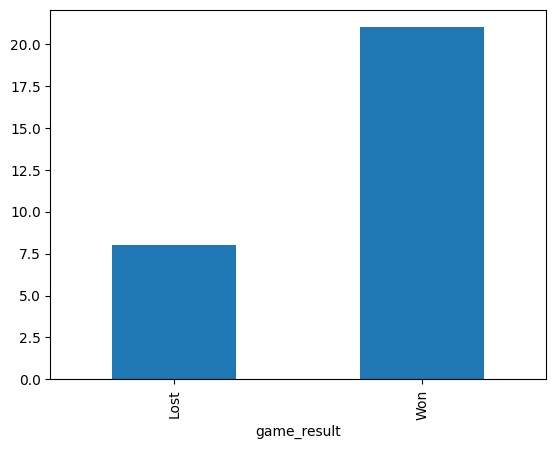

In [28]:
plot_game_result(daily_games)

game_result
Draw      9
Lost    107
Won     102
dtype: int64


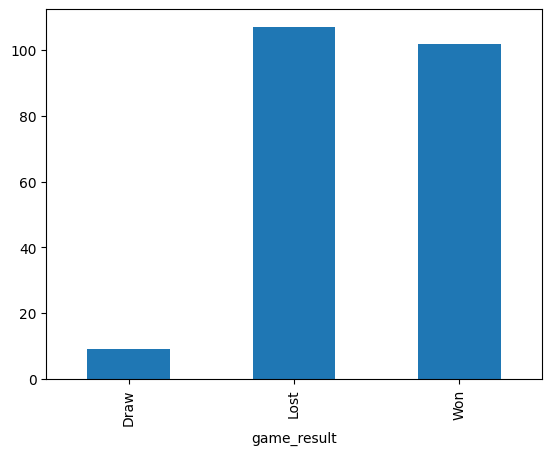

In [29]:
plot_game_result(rapid_games)

game_result
Draw     12
Lost    162
Won     154
dtype: int64


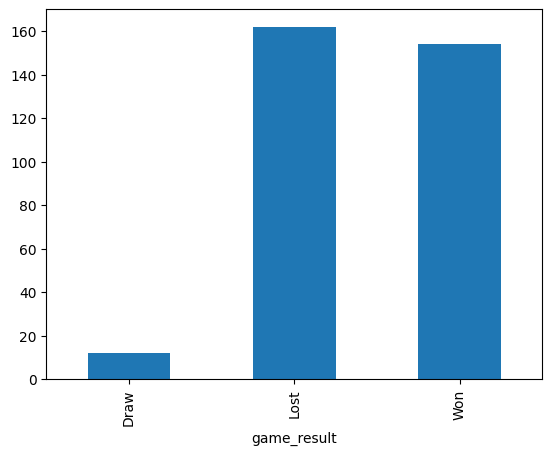

In [30]:
plot_game_result(blitz_games)

game_result
Draw     1
Lost    33
Won     23
dtype: int64


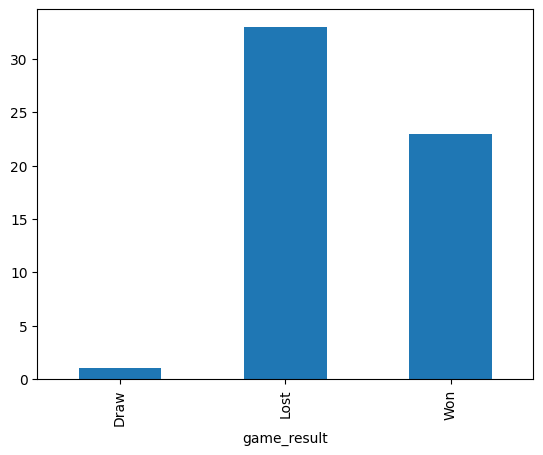

In [31]:
plot_game_result(bullet_games)

In [32]:
chess_games["openings"].nunique() # number of unique openings

290

In [33]:
openings = chess_games.groupby("openings").size().sort_values(ascending = False)
openings

openings
Queens-Pawn-Opening-Accelerated-London-System            25
Petrovs-Defense-Three-Knights-Game                       17
Four-Knights-Game-Italian-Variation                      13
Three-Knights-Opening-3...Bc5                            12
Philidor-Defense                                         12
                                                         ..
Kings-Pawn-Opening-Kings-Knight-Irish-Gambit-3...Nxe5     1
Kings-Pawn-Opening-Leonardis-Variation-2...Nf6            1
Kings-Pawn-Opening-Leonardis-Variation-2...Nf6-3.Nf3      1
Kings-Pawn-Opening-Tayler-Opening-3...Nf6-4.d3            1
Ware-Opening-Meadow-Hay-Mistake                           1
Length: 290, dtype: int64

### The plot below shows the top 10 openings played for all time controls

openings
Queens-Pawn-Opening-Accelerated-London-System      25
Petrovs-Defense-Three-Knights-Game                 17
Four-Knights-Game-Italian-Variation                13
Three-Knights-Opening-3...Bc5                      12
Philidor-Defense                                   12
Scandinavian-Defense-2.e5                          12
Vant-Kruijs-Opening-1...e5                          9
Kings-Pawn-Opening-Kings-Knight-Variation           9
Kings-Pawn-Opening-Kings-Knight-Damiano-Defense     9
Italian-Game                                        9
dtype: int64


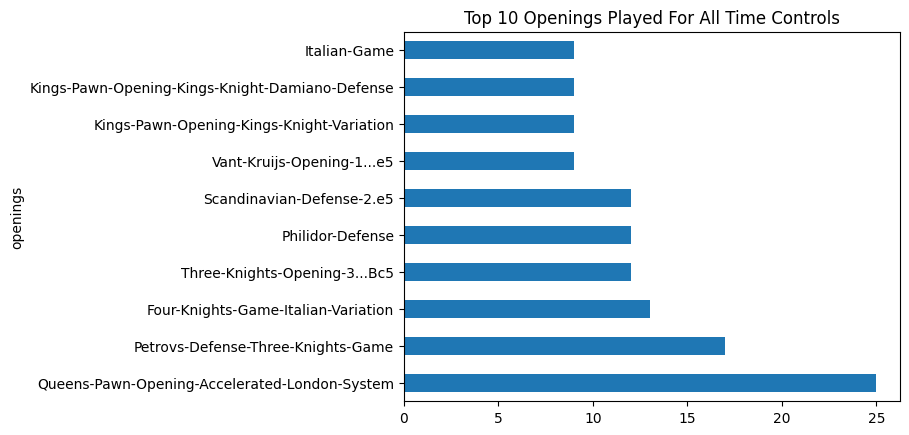

In [34]:
openings[:10].plot(kind = "barh", title = "Top 10 Openings Played For All Time Controls")
print(openings[:10])
plt.xticks(minor = True)
plt.show()

In [35]:
def plot_game_result_by_openings(df, result):
    df = df[["openings", "game_result"]].where(df["game_result"] == result).dropna()
    df.groupby("openings").size().sort_values(ascending = False)[:10].plot(kind = "barh", title = f"Top 10 Openings {result} All Time Controls")
    plt.xticks(minor = True)
    plt.show()

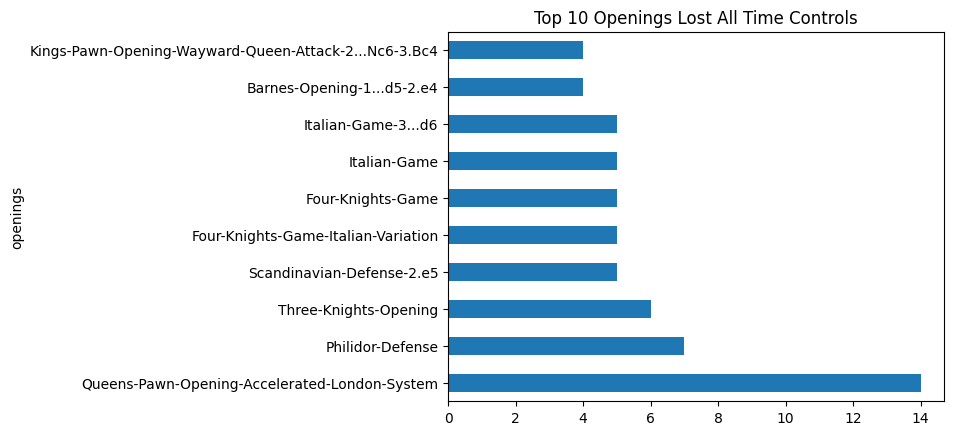

In [36]:
plot_game_result_by_openings(chess_games, "Lost")

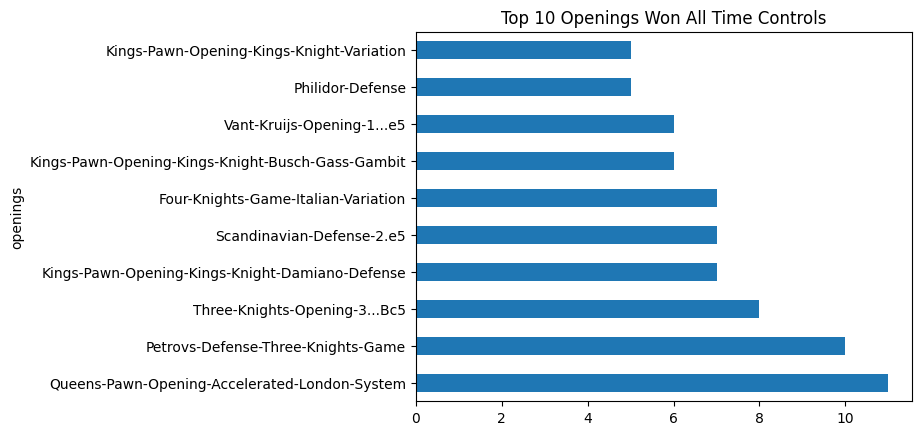

In [37]:
plot_game_result_by_openings(chess_games, "Won")

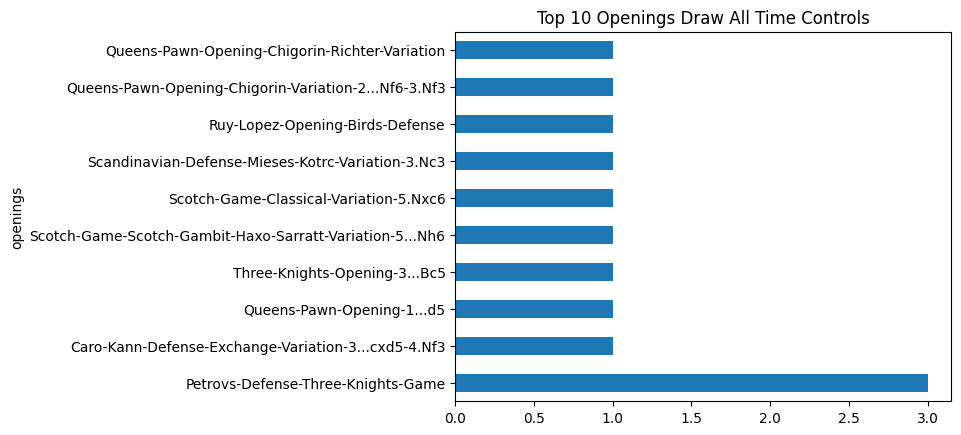

In [38]:
plot_game_result_by_openings(chess_games, "Draw")